In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timedelta

# Cargar el archivo CSV
file_path = 'FP com 08-22 a 08-24.csv'  # Ruta del archivo subido
df = pd.read_csv(file_path, encoding='latin-1')

pd.options.display.float_format = '{:,.2f}'.format


df = df[df[df.columns[18]] > 0]


# Diccionario para renombrar los ramos
ramos_dict = {
    1: "INCENDIO",
    2: "TRANSPORTE",
    3: "AERONAVEGACIÓN",
    4: "AUTOMOTORES",
    5: "CRISTALES",
    6: "ROBO",
    7: "RIESGOS VARIOS",
    8: "RESP. CIVIL",
    9: "SEGURO TÉCNICO",
    10: "RS. AGROPECUARIOS",
    12: "ACC. PERSONALES",
    13: "CAUCIÓN",
    17: "VIDA OBLIGATORIO",
    18: "VIDA COLECTIVO",
    19: "VIDA INDIVIDUAL",
    22: "CASCOS",
    24: "COMB FLIAR",
    25: "INDUSTRIA y COM.",
    35: "ACC. A PASAJEROS",
    36: "SEGURO DE SALUD",
    37: "SEGURO DE SEPELIO",
    44: "MOTOVEHÍCULOS",
    80: "ART"
}

# Reemplazar los números por nombres de ramos en la columna correspondiente
df[df.columns[8]] = df[df.columns[8]].map(ramos_dict)

# Filtrar el dataframe excluyendo ramos 12 (ACC. PERSONALES) y 19 (VIDA INDIVIDUAL)
df = df[~df[df.columns[8]].isin(["ACC. PERSONALES", "VIDA INDIVIDUAL"])]

# Diccionario para traducir meses en español a inglés
meses_espanol = {
    'ene': 'jan',
    'feb': 'feb',
    'mar': 'mar',
    'abr': 'apr',
    'may': 'may',
    'jun': 'jun',
    'jul': 'jul',
    'ago': 'aug',
    'sep': 'sep',
    'oct': 'oct',
    'nov': 'nov',
    'dic': 'dec'
}

# Reemplazar los meses en español por los meses en inglés en la columna 'Mes-Año'
df[df.columns[4]] = df[df.columns[4]].str[:3].replace(meses_espanol) + df[df.columns[4]].str[3:]

# Convertir la columna Mes-Año (columna 4) a tipo fecha usando el formato "%b-%y"
df[df.columns[4]] = pd.to_datetime(df[df.columns[4]], format='%b-%y', errors='coerce')

# Verificar si hay valores no convertidos (NaT)
if df[df.columns[4]].isnull().any():
    print("Algunos datos no se pudieron convertir a fecha. Revisa los valores no válidos:")
    print(df[df[df.columns[4]].isnull()])

# Unificar los productores 28978 y 33606
df[df.columns[24]] = df[df.columns[24]].replace({28978: 33606})

# Preguntar al usuario si desea filtrar por un Productor
productor_input = input("Elige el productor (Ej. 26357, deja vacío para no filtrar): ")

# Variable para almacenar la parte fija del título
titulo_fijo = ""

# Verificar si se ingresa un número de productor y ajustar la parte fija del título
if productor_input.isdigit():
    productor_input = int(productor_input)
    
    # Filtrar el DataFrame por el productor especificado
    df_prod = df[df[df.columns[24]] == productor_input]
    
    # Generar la parte fija del título correspondiente al Productor
    titulo_fijo = f" PAS {productor_input}"
    
    # Filtrar también el productor 26357 para comparación
    df_comp = df[df[df.columns[24]] == 26357]
    
else:
    # Si no se ingresa un productor, se toma toda la organización
    titulo_fijo = " de toda la org."
    df_prod = df
    df_comp = df[df[df.columns[24]] == 26357]

# Parte variable del título para este gráfico específico
titulo_variable = "Evolución de Cobros Totales por Mes-Año"

# Concatenar la parte variable y fija para formar el título final
titulo_grafico = f"{titulo_variable} {titulo_fijo}"



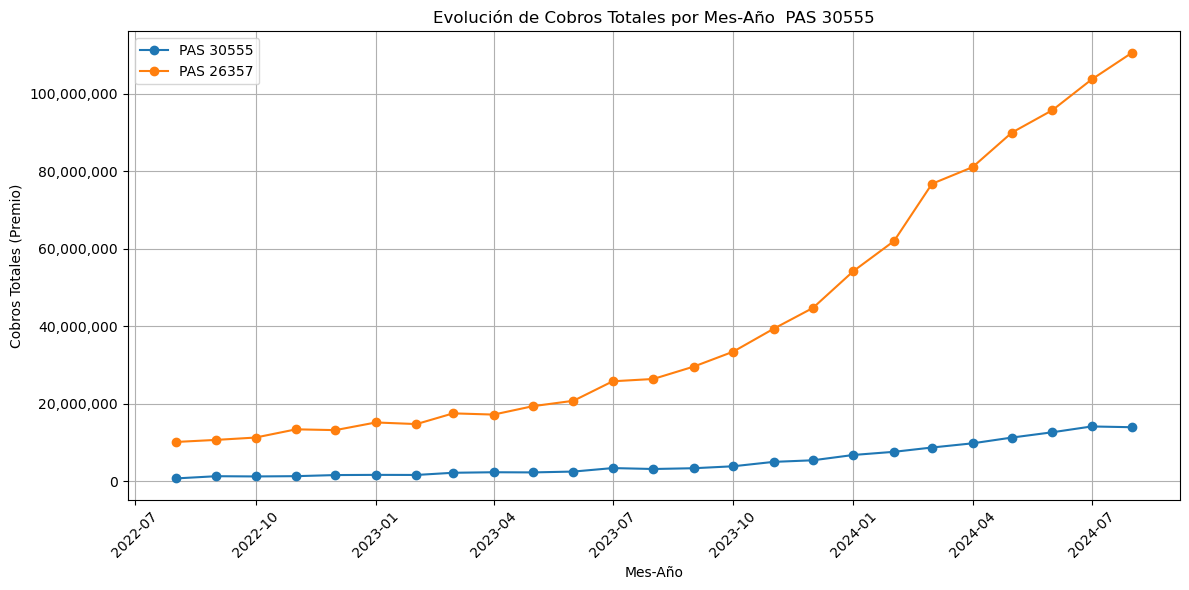

In [59]:
# 1. Evolución por cobros totales (sumatoria de Columna 19 Premio, agrupados por Columna 5 Mes-año)
evolucion_cobros_prod = df_prod.groupby(df_prod.columns[4])[df_prod.columns[18]].sum().reset_index()
evolucion_cobros_comp = df_comp.groupby(df_comp.columns[4])[df_comp.columns[18]].sum().reset_index()

# Crear un rango de fechas para el orden personalizado desde 08-22 hasta 08-24
fecha_inicio = pd.to_datetime("2022-08", format="%Y-%m")
fecha_fin = pd.to_datetime("2024-08", format="%Y-%m")
fechas_rango = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='MS')

# Filtrar y ordenar el DataFrame por el rango de fechas
evolucion_cobros_prod = evolucion_cobros_prod[evolucion_cobros_prod[df_prod.columns[4]].isin(fechas_rango)].sort_values(by=df_prod.columns[4])
evolucion_cobros_comp = evolucion_cobros_comp[evolucion_cobros_comp[df_comp.columns[4]].isin(fechas_rango)].sort_values(by=df_comp.columns[4])

# Convertir el valor de "Premio" a número para graficar
evolucion_cobros_prod['Premio_num'] = evolucion_cobros_prod[df_prod.columns[18]].replace({',': ''}, regex=True).astype(float)
evolucion_cobros_comp['Premio_num'] = evolucion_cobros_comp[df_comp.columns[18]].replace({',': ''}, regex=True).astype(float)

# Gráfico de líneas para la evolución de cobros totales comparado con el productor 26357
plt.figure(figsize=(12, 6))

# Evolución para el productor ingresado
plt.plot(evolucion_cobros_prod[df_prod.columns[4]], evolucion_cobros_prod['Premio_num'], marker='o', label=f'PAS {productor_input}')
# Evolución para el productor 26357
plt.plot(evolucion_cobros_comp[df_comp.columns[4]], evolucion_cobros_comp['Premio_num'], marker='o', label='PAS 26357')

# Título dinámico con parte fija y variable
plt.title(titulo_grafico)
plt.xlabel('Mes-Año')
plt.ylabel('Cobros Totales (Premio)')
plt.xticks(rotation=45)

# Aplicar formato a los números del eje Y
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Cantidad por ramo (Productor seleccionado):
               Ramo  Cantidad Polizas  % del total
7       RESP. CIVIL               632        47.16
2       AUTOMOTORES               578        43.13
6     MOTOVEHÍCULOS                56         4.18
9   SEGURO DE SALUD                31         2.31
3        COMB FLIAR                22         1.64
4          INCENDIO                 9         0.67
8              ROBO                 6         0.45
5  INDUSTRIA y COM.                 4         0.30
0  ACC. A PASAJEROS                 1         0.07
1               ART                 1         0.07

Cantidad por ramo (PAS 26357):
                 Ramo  Cantidad Polizas  % del total
2         AUTOMOTORES              4065        66.81
4          COMB FLIAR               469         7.71
11    SEGURO DE SALUD               375         6.16
5            INCENDIO               280         4.60
7       MOTOVEHÍCULOS               244         4.01
8         RESP. CIVIL               238     

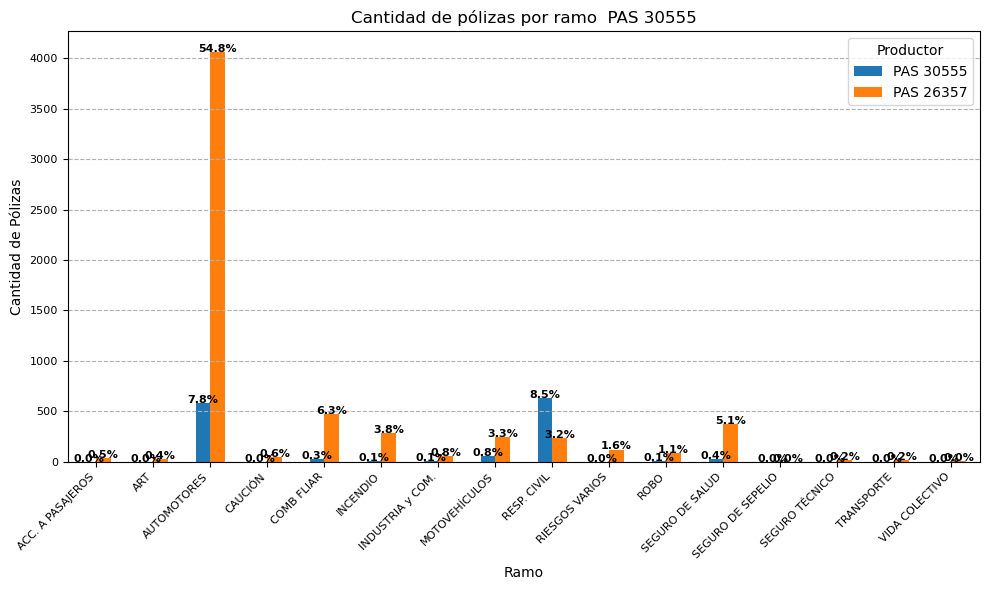

In [60]:
# Filtrar las pólizas únicas por ramo para el productor seleccionado
cantidad_por_ramo_prod = df_prod.groupby(df.columns[8])[df.columns[9]].nunique().reset_index()
cantidad_por_ramo_prod.columns = [df.columns[8], 'Cantidad Polizas']

# Filtrar las pólizas únicas por ramo para el productor 26357
cantidad_por_ramo_comp = df_comp.groupby(df.columns[8])[df.columns[9]].nunique().reset_index()
cantidad_por_ramo_comp.columns = [df.columns[8], 'Cantidad Polizas']

# Añadir columna de porcentaje para cada productor
cantidad_por_ramo_prod['% del total'] = (cantidad_por_ramo_prod['Cantidad Polizas'] / cantidad_por_ramo_prod['Cantidad Polizas'].sum()) * 100
cantidad_por_ramo_prod = cantidad_por_ramo_prod.sort_values(by='Cantidad Polizas', ascending=False)

cantidad_por_ramo_comp['% del total'] = (cantidad_por_ramo_comp['Cantidad Polizas'] / cantidad_por_ramo_comp['Cantidad Polizas'].sum()) * 100
cantidad_por_ramo_comp = cantidad_por_ramo_comp.sort_values(by='Cantidad Polizas', ascending=False)

# Mostrar en texto los reportes por ramo para ambos productores
print("\nCantidad por ramo (Productor seleccionado):")
print(cantidad_por_ramo_prod)

print("\nCantidad por ramo (PAS 26357):")
print(cantidad_por_ramo_comp)

# Definir la parte variable y fija del título
titulo_variable = "Cantidad de pólizas por ramo"
# Concatenar la parte variable y fija para formar el título final
titulo_grafico = f"{titulo_variable} {titulo_fijo}"

# Crear gráfico de barras
ax = comparativa_ramo.set_index(df.columns[8]).plot(
    kind='bar',
    figsize=(10, 6),
    y=[f'Cantidad Polizas_PAS{productor_input}', 'Cantidad Polizas_PAS26357'],
    label=[f'PAS {productor_input}', 'PAS 26357'],
    color=['#1f77b4', '#ff7f0e']
)

plt.title(titulo_grafico, fontsize=12)
plt.xlabel('Ramo', fontsize=10)
plt.ylabel('Cantidad de Pólizas', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)  # Tamaño de la fuente más pequeño para los rótulos de las barras
plt.yticks(fontsize=8)  # Tamaño de la fuente más pequeño para los números del eje Y

# Añadir porcentajes en las barras
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width/2, y + height + 0.5, '{:.1f}%'.format(
        (height / comparativa_ramo[[f'Cantidad Polizas_PAS{productor_input}', 'Cantidad Polizas_PAS26357']].values.sum()) * 100),
        ha='center', fontsize=8, weight='bold')  # Cambié el tamaño de la fuente de los porcentajes a 8

plt.legend(title="Productor", fontsize=10)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--')
plt.show()


C:\Users\Nico\AppData\Local\Temp\ipykernel_22156\2926733205.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[3]] = pd.to_datetime(df[df.columns[3]], errors='coerce')


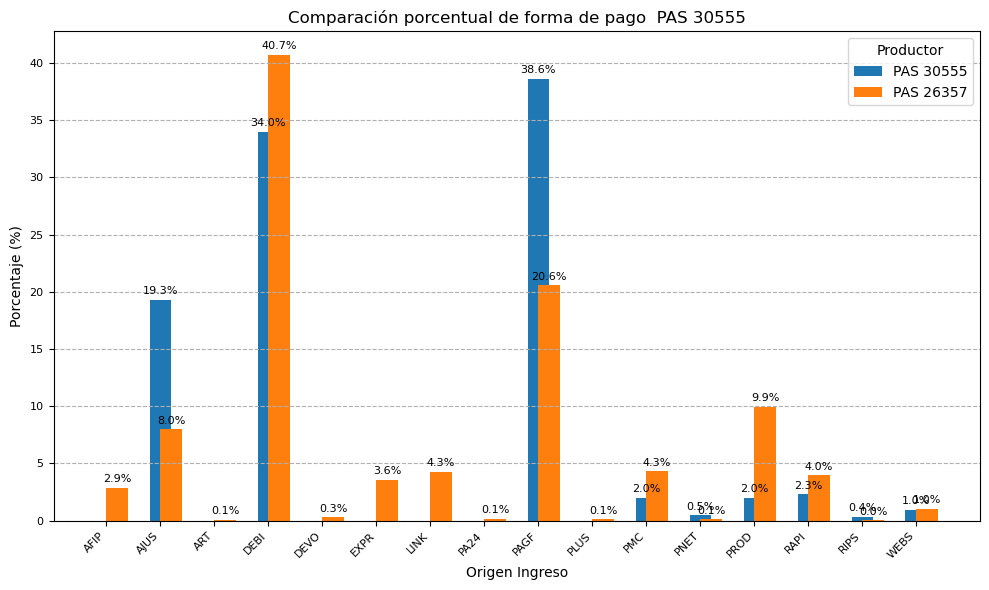

In [61]:
# Asegurarse de que la columna 'Fecha ingreso' (columna 4) esté en formato datetime
df[df.columns[3]] = pd.to_datetime(df[df.columns[3]], errors='coerce')

# Filtrar los últimos 30 días en la columna 'Fecha ingreso' (columna 4)
fecha_actual = datetime.now()
fecha_limite = fecha_actual - timedelta(days=30)

# Filtrar por los últimos 30 días y por productor
df_prod = df[(df[df.columns[3]] >= fecha_limite) & (df[df.columns[24]] == productor_input)]
df_comp = df[(df[df.columns[3]] >= fecha_limite) & (df[df.columns[24]] == 26357)]

# Agrupar por Origen Ingreso y calcular los porcentajes del premio
cantidad_por_forma_pago_prod = df_prod.groupby(df.columns[6])[df.columns[18]].sum().reset_index()
cantidad_por_forma_pago_comp = df_comp.groupby(df.columns[6])[df.columns[18]].sum().reset_index()

# Calcular el porcentaje del total para cada productor
cantidad_por_forma_pago_prod['% del total'] = (cantidad_por_forma_pago_prod[df.columns[18]] / cantidad_por_forma_pago_prod[df.columns[18]].sum()) * 100
cantidad_por_forma_pago_comp['% del total'] = (cantidad_por_forma_pago_comp[df.columns[18]] / cantidad_por_forma_pago_comp[df.columns[18]].sum()) * 100

# Ordenar de mayor a menor por porcentaje
cantidad_por_forma_pago_prod = cantidad_por_forma_pago_prod.sort_values(by='% del total', ascending=False)
cantidad_por_forma_pago_comp = cantidad_por_forma_pago_comp.sort_values(by='% del total', ascending=False)

# Fusionar los datos de ambos productores para la comparación por porcentaje
comparativa_pago = pd.merge(
    cantidad_por_forma_pago_prod[[df.columns[6], '% del total']],
    cantidad_por_forma_pago_comp[[df.columns[6], '% del total']],
    on=df.columns[6],
    how='outer',
    suffixes=(f'_PAS{productor_input}', '_PAS26357')
).fillna(0)

# Crear gráfico de barras para comparar porcentajes
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar para el productor seleccionado
ax.bar(comparativa_pago[df.columns[6]], comparativa_pago[f'% del total_PAS{productor_input}'], width=0.4, label=f'PAS {productor_input}', align='center')

# Graficar para el productor 26357
ax.bar(comparativa_pago[df.columns[6]], comparativa_pago['% del total_PAS26357'], width=0.4, label='PAS 26357', align='edge')

# Título y etiquetas del gráfico
plt.title(f'Comparación porcentual de forma de pago {titulo_fijo}', fontsize=12)
plt.xlabel('Origen Ingreso', fontsize=10)
plt.ylabel('Porcentaje (%)', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)  # Etiquetas más pequeñas
plt.yticks(fontsize=8)

# Añadir los porcentajes encima de las barras para ambos productores
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width() / 2., height + 0.5, '{:.1f}%'.format(height), ha='center', fontsize=8)

plt.legend(title="Productor", fontsize=10)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--')

plt.show()


Evolución de cantidad de pólizas COMB FLIAR por Mes-Año para ambos productores:
    Mes-Año  Cant Pol. COMB FLIAR PAS 30555  Cant Pol. COMB FLIAR PAS 26357
0   2022-08                               1                             100
1   2022-09                               3                             100
2   2022-10                               4                             100
3   2022-11                               3                              99
4   2022-12                               4                              99
5   2023-01                               4                             101
6   2023-02                               5                             102
7   2023-03                               8                             101
8   2023-04                               8                              99
9   2023-05                               8                             103
10  2023-06                               8                             113
11  202

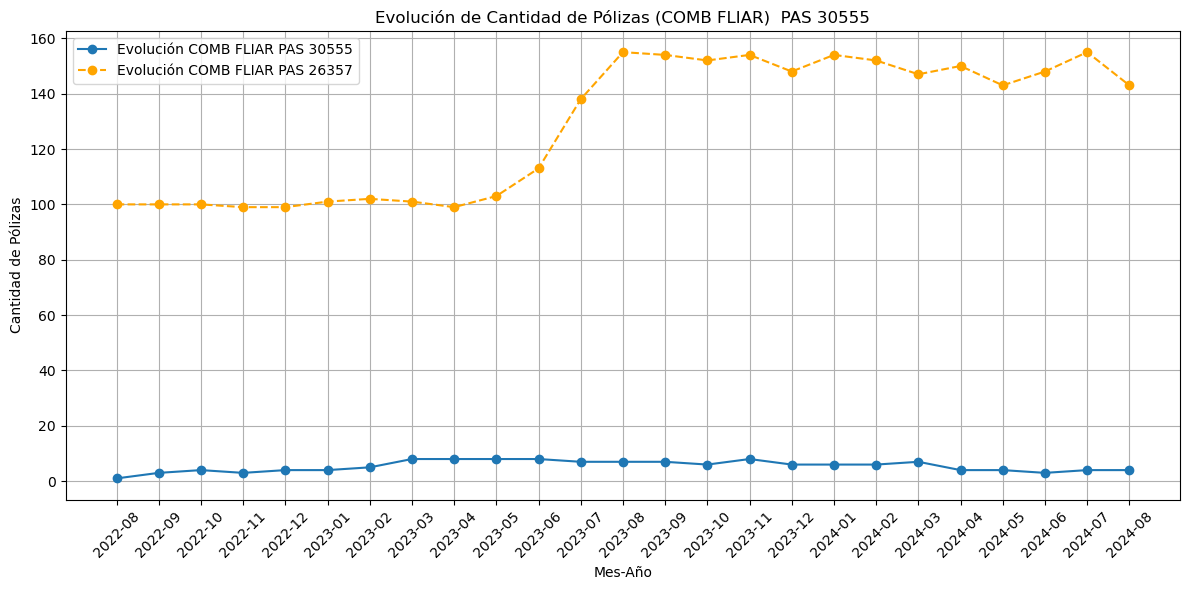

In [62]:
# Filtrar los casos en los que el "Premio" (Columna 19) sea mayor a 0 y el ramo sea "COMB FLIAR" para el productor seleccionado y 26357
df_filtrado_prod = df[(df[df.columns[18]] > 0) & (df[df.columns[8]] == "COMB FLIAR") & (df[df.columns[24]] == productor_input)].copy()
df_filtrado_comp = df[(df[df.columns[18]] > 0) & (df[df.columns[8]] == "COMB FLIAR") & (df[df.columns[24]] == 26357)].copy()

# Convertir la columna Mes-Año (columna 5) a tipo fecha para ambos dataframes
df_filtrado_prod[df.columns[4]] = pd.to_datetime(df_filtrado_prod[df.columns[4]], format='%m-%Y', errors='coerce')
df_filtrado_comp[df.columns[4]] = pd.to_datetime(df_filtrado_comp[df.columns[4]], format='%m-%Y', errors='coerce')

# Extraer solo Mes-Año
df_filtrado_prod['Mes-Año'] = df_filtrado_prod[df.columns[4]].dt.to_period('M')
df_filtrado_comp['Mes-Año'] = df_filtrado_comp[df.columns[4]].dt.to_period('M')

# Eliminar duplicados por 'Poliza' y 'Mes-Año' para evitar contar la misma póliza más de una vez por mes
df_filtrado_prod = df_filtrado_prod.drop_duplicates(subset=[df.columns[9], 'Mes-Año'])
df_filtrado_comp = df_filtrado_comp.drop_duplicates(subset=[df.columns[9], 'Mes-Año'])

# Conteo de pólizas únicas por mes-año (solo "COMB FLIAR") para ambos productores
evolucion_comb_fliar_prod = (
    df_filtrado_prod
    .groupby('Mes-Año')[df.columns[9]]  # Agrupar por Mes-Año y contar pólizas únicas
    .count()
    .reset_index()
)
evolucion_comb_fliar_prod.columns = ['Mes-Año', f'Cant Pol. COMB FLIAR PAS {productor_input}']

evolucion_comb_fliar_comp = (
    df_filtrado_comp
    .groupby('Mes-Año')[df.columns[9]]  # Agrupar por Mes-Año y contar pólizas únicas
    .count()
    .reset_index()
)
evolucion_comb_fliar_comp.columns = ['Mes-Año', 'Cant Pol. COMB FLIAR PAS 26357']

# Fusionar ambas series de tiempo para la comparación en una tabla conjunta
evolucion_comb_fliar = pd.merge(evolucion_comb_fliar_prod, evolucion_comb_fliar_comp, on='Mes-Año', how='outer').fillna(0)

# Mostrar la tabla conjunta en consola
print("\nEvolución de cantidad de pólizas COMB FLIAR por Mes-Año para ambos productores:")
print(evolucion_comb_fliar)

# Definir la parte variable del título
titulo_variable = "Evolución de Cantidad de Pólizas (COMB FLIAR)"
# Concatenar la parte variable y fija del título
titulo_grafico = f"{titulo_variable} {titulo_fijo}"

# Crear el gráfico de líneas para la evolución de COMB FLIAR comparado con el productor 26357
plt.figure(figsize=(12, 6))

# Línea para la evolución de COMB FLIAR del productor seleccionado
plt.plot(
    evolucion_comb_fliar['Mes-Año'].astype(str),  # Convertir a string para que se vea correctamente en el gráfico
    evolucion_comb_fliar[f'Cant Pol. COMB FLIAR PAS {productor_input}'], 
    label=f'Evolución COMB FLIAR PAS {productor_input}', 
    marker='o'
)

# Línea para la evolución de COMB FLIAR del productor 26357
plt.plot(
    evolucion_comb_fliar['Mes-Año'].astype(str), 
    evolucion_comb_fliar['Cant Pol. COMB FLIAR PAS 26357'], 
    label='Evolución COMB FLIAR PAS 26357', 
    marker='o', linestyle='--', color='orange'
)

# Títulos y etiquetas
plt.title(titulo_grafico)  # Título dinámico con parte variable y fija
plt.xlabel('Mes-Año')
plt.ylabel('Cantidad de Pólizas')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()